<h1> Monte Carlo Markov Chains and Cluster Mass Reconstruction </h1>


<h2> A small primer on classes in Python</h2>

The following code consists of different modules, and each of them is written as a *class*. You can find some examples for class definitions in the following cell:

In [1]:
#import some modules for math and integrations
from scipy import integrate
import numpy as np
import timeit

#define classes with constants used later
class Constants:
    """
    Defines fundamental physical constants.
    """
    ckms = 3.0e5 # speed of light in km/s 
    rho_crit0 = 2.7751973751261264e11 # rho_crit(z=0) in units of h^-1 Msun/ h^-3 Mpc^3
    G = 4.3e-9 # G in units of Mpc/Msun /(km/s)^2

class Cosmology:
    """
    Defines a flat LCDM background cosmology.
    """
    Omega_m = 0.27
    Omega_L = 1. - Omega_m #assumes flatness

<h2>$\chi^2$ Calculation</h2>

This class contains all functions necessary to calculate the goodness-of-fit for a given set halo of mass and concentration $(M,c)$. We define the quadratic deviations from the measured shear values:

$$ \chi^2(M,c) = \sum_i^N \frac{(\gamma_\mathrm{theo, i}(M,c) - \gamma_\mathrm{dat, i})^2}{\sigma^2_\gamma} $$

The theoretical shear values are calculated by assuming a Navarro-Frenk-White (NFW) density profile:

$$ \rho_\mathrm{NFW}(r) = \frac{\delta_c \rho_c}{(r/r_s)(1 + r/r_s)^2} \: , $$

which leads to

$$ \gamma(x_i) = \frac{r_s(M,c) \; \delta_c(c) \; \rho_c(z_\mathrm{lens})}{\Sigma_c(z_\mathrm{lens},z_\mathrm{source})} g(x_i) \: , $$


where $g(x)$ is an auxiliary function for the dimensionless distance from the lens $x = \theta/\theta_s$. Take care, you have to distinguish $g(x)$ for the cases $x<0$ and $x>0$. When calculating $\chi^2$, try not to write loops over the whole data array - they are quite slow in python. Numpy arrays however do support fast vectorized operations.

Speed matters here. Try to optimise your $\chi^2$ calculation, remember that this routine is called several thousand times when used as part of a chain. You can check your execution time with the `%timeit my_function(x,y,..)` command.

In [2]:
class ClusterLikelihood:
    
    def __init__(self):
        """
        Initialise arrays and variables.
        """
        # class variables
        self.sigmashear = 0.3
        self.zlens = 0.245
        self.zsource = 1.0
        self.rho_crit_zlens= Constants.rho_crit0 * self.E(self.zlens)**2
        
        # initialise arrays
        """
        Note: the halo5.tab file including the shear data has to be in the same folder as this notebook,
        or you can also adjust the path in np.loadtxt() to 'my/folder/halo5.tab'.
        If the file is missing, download it here:
        https://dmz-sv-owncloud.physik.uni-muenchen.de/public.php?service=files&t=fac80dcbbccd5258a0d4ae1f9921adb9
        """
        self.data = np.loadtxt('halo5.tab')
        self.THETADAT = self.data[:,3] # angular distance in arcmin
        self.SHEARDAT = self.data[:,5] # measured shear signal
        self.RDAT = self.angular_distance(self.zlens)*self.THETADAT*np.pi/180.0/60.0 # physical distance
        
        self.DATA = np.zeros((self.THETADAT.size,2))
        self.DATA[:,0] = self.RDAT
        self.DATA[:,1] = self.SHEARDAT

    def E(self,z):
        """
        Calculates the dimensionless Hubble function.

        Parameters:
        ----------
        z : redshift

        Returns:
        ----------
        E(z) : Dimensionless Hubble function E(z)=H(z)/H0
        """
        E = np.sqrt(Cosmology.Omega_m*(1.+z)**3 + Cosmology.Omega_L)
        return E

    def angular_distance(self,z):
        """
        Calculates angular diameter distances. Assumes a fixed LCDM cosmology
        defined in the Cosmology class.

        Parameters:
        ----------
        z : redshift

        Returns :
        ----------
        d_A(z) : angular diameter distance in Mpc/h
        """
        integral, error = integrate.quad(self.integrand_angular_distance,0.,z,epsrel=1e-4)
        d_A = integral * Constants.ckms*1e-2/(1.+z)
        return d_A

    def integrand_angular_distance(self,z):
        """
        Integrand for the angular diameter distance calculation.

        Parameters:
        ----------
        z : redshift

        Returns:
        ----------
        1./E(z) : Inverse dimensionless Hubble function 1./E(z)=H0/H(z)
        """
        return 1./self.E(z)

    def Sigma_critical(self,z_lens,z_source):
        """
        Calculates the critical surface density.

        Parameters:
        ----------
        z_lens    : lens redshift
        z_source  : source redshift

        Returns:
        ----------
        Sigmac : critical surface density
        """
        D_source = self.angular_distance(z_source)
        D_lens = self.angular_distance(z_lens)
        D_lens_source = D_source - (1.0+z_lens)*D_lens/(1.+z_source)    
        Sigmac = Constants.ckms**2*D_source/D_lens/D_lens_source/np.pi/Constants.G/4.
        return Sigmac

    def g_less(self,x):
        """
        Auxiliary function g(x) for shear calculation, assumes x < 1.

        Parameters:
        ----------
        x : array_like, dimensionless radial distance between source and lens

        Returns:
        ----------
        result : array_like with same shape as x, analytic shear
                 integral for a NFW density profile
        """
        arctan = np.arctanh(np.sqrt((1.-x)/(1.+x)))
        x_sq = x*x
        term1 = 8.*arctan/x_sq/np.sqrt(1.-x**2) + 4./x_sq*np.log(x/2.) - 2./(x_sq-1)
        result = (term1 + 4.*arctan/(x_sq-1.)/np.sqrt(1.-x_sq))
        return result

    def g_larger(self,x):
        """
        Auxiliary function g(x) for shear calculation, assumes x > 1.

        Parameters:
        ----------
        x : array_like, dimensionless radial distance between source and lens

        Returns:
        ----------
        result : array_like with same shape as x, analytic shear
                 integral for a NFW density profile
        """
        arctan = np.arctan(np.sqrt((x-1.)/(1.+x)))
        x_sq = x*x
        term1 = 8.*arctan/x_sq/np.sqrt(x**2-1.) + 4./x_sq*np.log(x/2.) - 2./(x_sq-1)
        result = (term1 + 4.*arctan/(x_sq-1.)**1.5)
        return result

    def chi_sq(self,M200,c200):
        """
        Calculates chi**2 values.

        Parameters:
        ----------
        M200 : Mass of the lens enclosed within a radius r200 where the mean density is 200 times
               larger than the background matter density
        c200 : Halo concentration at radius r200

        Returns:
        ----------
        chi_sq : summed chi**2 values for all source galaxies
        """
        x = self.RDAT/self.scale_radius_nfw(M200,c200)
        
        gamma_theor = (((self.scale_radius_nfw(M200,c200) * self.delta_c(c200) * self.rho_crit_zlens) 
                       / self.Sigma_critical(self.zlens,self.zsource))
                    *np.append(self.g_less(x[x<1]),self.g_larger(x[x>1])))
                        
        """
        gamma_theor = (((self.scale_radius_nfw(M200,c200) * self.delta_c(c200) * self.rho_crit_zlens) 
                       / self.Sigma_critical(self.zlens,self.zsource))*
                        np.where(x<1,self.g_less(x),self.g_larger(x)))
        """
        chi_sq = np.sum((gamma_theor-np.append(self.SHEARDAT[x<1],self.SHEARDAT[x>1]))**2 / (self.sigmashear)**2)
        return chi_sq
        """
        Implement the chi**2 calculation here. Make use of the other functions already defined in this class.
        Keep in mind that you can pass arrays to the g_larger/g_less functions to avoid loops wherever possible.
        """
        

    def scale_radius_nfw(self,M200,c200):
        """
        Calculates scale radius of a NFW profile.

        Parameters:
        ----------
        M200 : Mass of the lens enclosed within a radius r200 where the mean density is 200 times
               larger than the background matter density
        c200 : Halo concentration at radius r200

        Returns:
        ----------
        r_s : scale radius
        """            
        r_s = (3.0*M200/800.0/np.pi/self.rho_crit_zlens/c200**3)**(1./3.)
        return r_s

    def delta_c(self,c200):
        """
        Calculates the central density contrast for a NFW profile.

        Parameters:
        ----------
        c200 : Halo concentration at radius r200

        Returns:
        ----------
        delta_c : central density contrast 
        """    
        delta_c = 200.*c200**3/(np.log(1.+c200) - c200/(1.+c200))/3.
        return delta_c


In [3]:
my_instance = ClusterLikelihood()
#%timeit my_instance.chi_sq(1e14,5)

In [4]:
%timeit my_instance.chi_sq(1e14,5)

149 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import colors, ticker, cm

grid_size = 50
M_grid = np.linspace(14, 16, grid_size)
C_grid = np.linspace(2, 10, grid_size)

M, C = np.meshgrid(M_grid, C_grid)

chi_sq = np.zeros([grid_size, grid_size])

for i in range(grid_size):
    for j in range(grid_size):
        chi_sq[i,j] = my_instance.chi_sq(10**M_grid[i],C_grid[j])

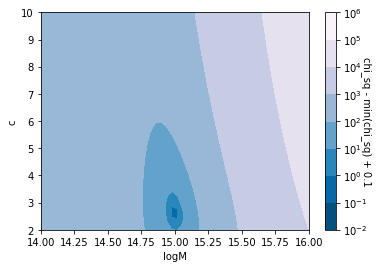

In [6]:
#chi_sq values are heavily concentrated around the minimum, hence the values are scaled by log(chi_sq-min(chi_sq)+1) in order to make a 2d plot
fig, ax = plt.subplots()
cs = ax.contourf(M,C, np.transpose(chi_sq-np.min(chi_sq)+0.1), locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
plt.xlabel('logM')
plt.ylabel('c')
cbar.set_label('chi_sq - min(chi_sq) + 0.1', rotation=270)
plt.show()

In [8]:
for i in range(grid_size):
    for j in range(grid_size):
        if chi_sq[i,j] == np.min(chi_sq):
            print ('Values of logM and c where Chi_Square is Minimum are:', M_grid[i], C_grid[j])

Values of logM and c where Chi_Square is Minimum are: 14.979591836734693 2.6530612244897958


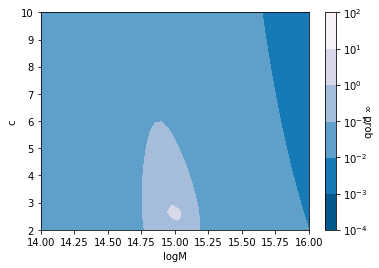

In [9]:
prob = np.exp(-0.5*np.log(chi_sq - np.min(chi_sq)+0.1))
fig, ax = plt.subplots()
cs = ax.contourf(M,C, np.transpose(prob), locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
plt.xlabel('logM')
plt.ylabel('c')
cbar.set_label('∝ prob', rotation=270)
plt.show()

Now implement a loop over $M$ and $c$ to estimate the minimal $\chi^2$ (this is called a grid search). Plot your results to get a rough idea for the shape of the $\chi^2$-distribution (note that this is equivalent to a Gaussian likelihood).

<h2>Metropolis Hastings Algorithm</h2>

In [10]:
class Sampler(ClusterLikelihood):
    
    def __init__(self):
        """
        Initialise Likelihood class and define allowed parameter range with their covariance.
        """
        ClusterLikelihood.__init__(self)
        # set priors on allowed (log10(M), c) range. Note: sampling in log10(M)
        self.parmin = [10,0.1]
        self.parmax = [20,10]
        # covariance matrix: feel free to play around with these values
        self.cov = np.diag((0.1,0.1))
        # initial values: randomly chosen in the allowed parameter range
        self.params = np.random.uniform(self.parmin,self.parmax)
        
        
    def check_param_range(self,x):
        """
        Check if current parameter vector x is in the allowed range.
        """
        for index, aux in enumerate(x):
            if aux > self.parmax[index]:
                x[index] = self.parmax[index]
            if aux < self.parmin[index]:
                x[index] = self.parmin[index]

    def MCMC(self,NSTEP,filename='chain.txt',write_file=False):
        """
        Runs a Monte Carlo Markov Chain.

        Parameters:
        ----------
        NSTEP      : int
                     Number of chain steps (including not accepted ones)
        filename   : string, optional
                     Name of data output file
        write_file : bool, optional
                     Control if the chain should be printed to the screen (default: write_file = False)
                     or saved to a file specified by 'filename' (default: chain.txt)
        """    
        #open file to write chain and write header
        if write_file == True:
            chain = open(filename,'w')
            chain.write("#counter multiplicity chi**2 M200 c200 a b\n")
        multiplicity = 1
        counter = 0
        old_chi_sq = self.chi_sq(10.**self.params[0], self.params[1])
        for i in range(NSTEP):
            #draw a new parameter vector
            self.newparams = np.random.multivariate_normal(self.params,self.cov)
            self.check_param_range(self.newparams)
            new_chi_sq = self.chi_sq(10.**self.newparams[0], self.newparams[1])
            b = np.random.uniform(0,1)
            a = np.exp(-0.5*(new_chi_sq-old_chi_sq))
            if np.min([1,a])>=b:
                self.params = self.newparams
                old_chi_sq = new_chi_sq
                multiplicity = 1
            elif np.min([1,a])<b:
                multiplicity = multiplicity+1
            counter=counter+1
            """
            """
            """
            Implement the Metropolis Hastings algorithm here following the pseudo-code in the script.
            Use the following code fragment to write out the data in case a step is accepted
            (either to the screen or a file):
            """
            if write_file == True:
                chain.write("%d %d %.2f %.6f %.2f %.6f %.6f\n" %(counter, multiplicity, old_chi_sq, self.params[0], self.params[1],a,b))
            else:
                print("%d %d %.2f %.2e %.2f %.6f %.6f" %(counter, multiplicity, old_chi_sq, 10.**self.params[0], self.params[1],a,b))
            """
            """
            """
            """
        print ("-"*40)
        print ("chain finished after %d steps" %NSTEP)
        if write_file == True:
            chain.close()


In [11]:
samplerinstance = Sampler()

In [12]:
samplerinstance.MCMC(1000,write_file=True,filename='chain.txt')

----------------------------------------
chain finished after 1000 steps


In [13]:
import pandas as pd
data1 = pd.read_table('chain.txt',sep=' ')
data2 = pd.read_table('chain2.txt',sep=' ')
data3 = pd.read_table('chain3.txt',sep=' ') #SD has been increased to 0.5 for both parameters

FileNotFoundError: File b'chain2.txt' does not exist

In [ ]:
plt.plot(data1['M200'],label = 'Chain1 sd=0.1');
plt.plot(data2['M200'],label = 'Chain2 sd=0.1');
plt.plot(data3['M200'],label = 'Chain3 sd=0.5');
plt.legend(loc='best');
plt.ylabel('logM');
plt.xlabel('Step');

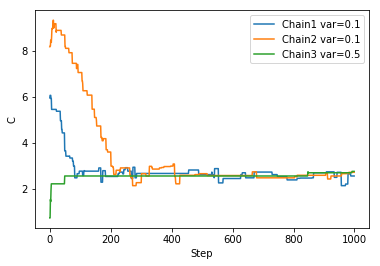

In [160]:
plt.plot(data1['c200'],label = 'Chain1 var=0.1');
plt.plot(data2['c200'],label = 'Chain2 var=0.1');
plt.plot(data3['c200'],label = 'Chain3 var=0.5');
plt.legend(loc='best');
plt.ylabel('C');
plt.xlabel('Step');

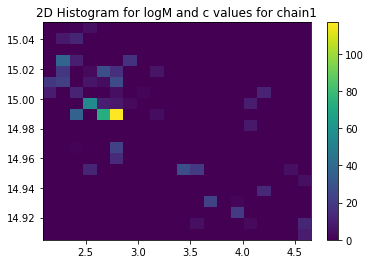

In [14]:
hist = plt.hist2d(data1['c200'][200:], data1['M200'][200:],bins=(20,20))
plt.colorbar(hist[3])
plt.title('2D Histogram for logM and c values for chain1');

In [167]:
print(np.mean(data2['M200'][200:]))
print(np.std(data2['M200'][200:]))
print(np.mean(data2['c200'][200:]))
print(np.std(data2['c200'][200:]))
print(len(data2['c200'][200:]))

15.00431394999995
0.019466412528506515
2.6265499999999857
0.1767430267365607
800


<h2>Plotting and analysis</h2>


In [15]:
from getdist import plots, MCSamples
import getdist, IPython
import os
import matplotlib.pylab as plt
%matplotlib inline

#This just creates some random mock data we use for demonstration purposes
ndim = 4
nsamp = 10000
np.random.seed(10)
A = np.random.rand(ndim,ndim)
cov = np.dot(A, A.T)
samps = np.random.multivariate_normal([0]*ndim, cov, size=nsamp)

# now we create some names and LaTeX labels
names = ["x%s"%i for i in range(ndim)]
labels =  ["x_%s"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)

# save the mock chains
samples.saveAsText('chain_example')

Removed no burn in


In [16]:
# load the chain
chain = np.loadtxt('chain.txt')
names = ['#counter','multiplicity','chi2','logM200','c200','a','b']
labels =  ['#counter','multiplicity','chi2','logM200','c200','a','b']
# Note that the chain in this example contains the weights and log-likelihood as the first two columns
samples = MCSamples(samples=chain[200:],names = names, labels=labels, loglikes = np.log(chain[200:,5:6]),weights=1)

# create a new Plotter object
g = plots.getSubplotPlotter(subplot_size=3)

Removed no burn in


C:\Users\vip\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\vip\Anaconda3\lib\site-packages\getdist\mcsamples.py:2041: RuntimeWarning: invalid value encountered in subtract
  m.logMeanLike = -np.log(self.mean(np.exp(-(self.loglikes - maxlike)))) + maxlike
C:\Users\vip\Anaconda3\lib\site-packages\getdist\mcsamples.py:2043: RuntimeWarning: invalid value encountered in subtract
  m.complexity = 2 * (self.mean_loglike - maxlike)


Now we can make some plots and save them with `g.export('NAME.PDF')`:

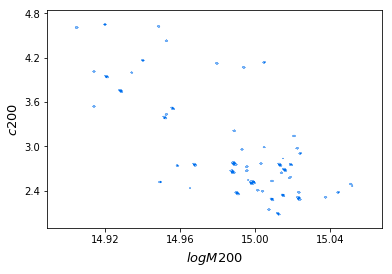

In [27]:
# Note: you always refer to parameter with the name, the plot will show the label
g.plot_2d(samples, 'logM200', 'c200',filled=True)
g.export('2d_plot.png')

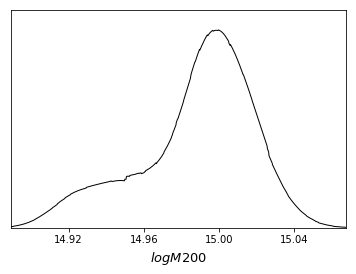

In [18]:
g.plot_1d(samples, 'logM200',filled=True)
g.export('1d_plot_logM.png')

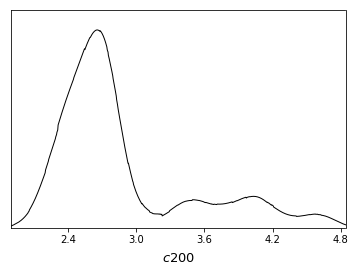

In [19]:
g.plot_1d(samples, 'c200',filled=True)
g.export('1d_plot_c.png')